# The aim is to see if we can estimate aniamls postion of left runs from data of right runs and vice versa

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
from scipy.stats import mode
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths
from sklearn.model_selection import GroupShuffleSplit


Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:

def compute_allinfo(all_rates,P_x,r0,num_neurons):
    all_I_f = np.zeros(num_neurons)  # Forward I

    for nid in range(num_neurons):
    # ================================= Exercise starts here ========================================
    
        all_I_f[nid] = pf.computeSpatialInfo(all_rates[nid, :], P_x, r0[nid])
    return(all_I_f)

In [13]:
import configparser
import os
from pathlib import Path
onfig = configparser.ConfigParser()
# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)

Base Directory: c:\Users\hamed\Desktop\Hamed\Github\TP7
Skeletons Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\skeleton\
Save Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\
Data Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\


In [14]:
# Analysis parameters
exclude_peak_neighs=0
include_peak_neighs=0
MSEs_all={}

fs = 20# sampling freq
dt = 1/fs  # bin size of each time index
dy = 0.001 # bin size for position histogram. Since we will smooth the histogram anyways, the smaller the better (approaching Kernel Density Estimation).
sigma_y = 0.05 # I do not know the size of the animal. So, assume it to be 1% of the track.
sigma_yidx = sigma_y/dy  # Convert the position unit to unit of array index.
yedges = np.arange(0-dy/2, 1+dy, dy)  # edges for histogram
y_ax = pf.MidAx(yedges)  # position axis, mainly for plotting. Since edges are just for histogram.
#savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
#savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
#celltype='PC'
celltype='Alltest_neworder'
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst
data_info={'R':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]},'L':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]}
           ,'R from L':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]},'L from R':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]}
           ,'R from L Shuffled':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]},'L from R Shuffled':{'y':[],'neuron_tspidx':[],'burst_tidxs':[],'burst_cluids':[]}}


## Load data of Right outward runs

In [15]:
# In this code i load the data from outward runs and find the cells which are place cells.
#burst_len='500ms'

fol='485'
phase='learned'
y_len=[]
for dir_of_run in ['R','L']:
    #ilename = fol+'outward_'+dir_of_run+'_all_correct_No_chunk_'+burst_len+'_transients_'+celltype
    filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

    data_right = np.load(join(savefolder, filename), allow_pickle=True)





    y_len.append(data_right['lin_pos'].shape[0])

    print(data_right['lin_pos'].shape[0])



for dir_of_run in ['R','L']:

    #filename = fol+'outward_'+dir_of_run+'_all_correct_No_chunk_'+burst_len+'_transients_'+celltype
    filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

    data_right = np.load(join(savefolder, filename), allow_pickle=True)
    trial_labels = data_right['trial_idx_mask']#np.array([int(i) for i in data_right['trial_idx_mask'].split(',')])
    # Create GroupShuffleSplit instance
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Get the indices for training and testing sets
    train_idx, test_idx = next(gss.split(data_right['lin_pos'], groups=trial_labels))

    #bound_right = [0, np.min(y_len)] #if turn_type == 'left' else [sepidx, endind]  
    bound_right =[0, data_right['lin_pos'].shape[0]]
    y_right, neuron_tspidx_right, burst_tidxs_right, burst_cluids_rith, num_neurons, dt = pf.GetData(data_right, bound=bound_right)

    data_info[dir_of_run]['y']=y_right
    data_info[dir_of_run]['neuron_tspidx']=neuron_tspidx_right
    data_info[dir_of_run]['burst_tidxs']=burst_tidxs_right
    data_info[dir_of_run]['burst_cluids']=burst_cluids_rith




    # Creating a mask array for excluding position bins at the burst events (with neighbouring number of index = 1)
    #expanded_all_burst_tidxs = pf.expand_neighbins(burst_tidxs_right, expand_neighs=exclude_peak_neighs)
    expanded_all_burst_tidxs=test_idx
    y_tax = np.arange(data_info[dir_of_run]['y'].shape[0])
    y_tax_excluded = pf.exclude_idx(y_tax, expanded_all_burst_tidxs)
    y_excluded = data_info[dir_of_run]['y'][y_tax_excluded]

    # Compute the occupancy, using only those admitted position points
    data_info[dir_of_run]['occ'], data_info[dir_of_run]['occ_gau'] = pf.GetOccupancy(y_excluded, yedges, dt, sigma_yidx)



    data_info[dir_of_run]['r_all']  = np.zeros((num_neurons, y_ax.shape[0])).astype(float)  # for storing firing rates
    p_all=  np.zeros(y_ax.shape[0]).astype(float)

    for nid in range(num_neurons):
        tspidx = data_info[dir_of_run]['neuron_tspidx'][nid]
        masked_tspidx = pf.exclude_idx(tspidx, test_idx)# dont exclude any point for thi purpose
        neuron_ysp  = data_info[dir_of_run]['y'][masked_tspidx]
        rate, counts_ysp_gau,P_x = pf.GetRate(neuron_ysp, data_info[dir_of_run]['occ_gau'] , yedges, sigma_yidx)
        # Exclude spike times occuring in the neighours(=1) of the burst events.
        #masked_tspidx = pf.exclude_idx(tspidx, [])# dont exclude any point for thi purpose
        # Get "spike positions"
        #neuron_ysp= data_info[dir_of_run]['y'][masked_tspidx]
        # Store all of them
        data_info[dir_of_run]['r_all'][nid, :] = rate
        p_all=P_x






    trajtidx = np.arange(data_info[dir_of_run]['y'].shape[0])
    data_info[dir_of_run]['all_L_norm'] = np.zeros((y_ax.shape[0], trajtidx.shape[0]))


    # Loop through all time indexes to decode the positions.
    # Looping each time index is not so efficient. Vectorization is recommended if you do not need to include the neighbouring bins for decoding.
    for trajtidx_each in trajtidx[test_idx]:
        print('\r%d/%d'%(trajtidx_each, trajtidx.shape[0]), end="", flush=True)
        
        # Decode each time index. 
        _, L_norm = pf.decode_neighbins(trajtidx_each, y_ax, data_info[dir_of_run]['r_all'], data_info[dir_of_run]['neuron_tspidx'], dt=dt, num_neigh=include_peak_neighs)
        data_info[dir_of_run]['all_L_norm'] [:, trajtidx_each] = L_norm





    # Take the maximum of posterior probabilities across the position as the prediction 
    # It is the maximum likelihood (ML) estimator.
    yidx_max = np.argmax(data_info[dir_of_run]['all_L_norm'], axis=0)
    y_ML = y_ax[yidx_max][test_idx]

    biased_y = mode(y_ML)
    print('The biased y estimator value is ', biased_y, '\nPlease make sure the value corresponds to the most overrepresented ML estimator in the trajectory decoding above.')
    biased_yidx = np.where(y_ax == biased_y.mode[0])[0][0]
    print('The index of the position bin corresponding to this biased value \n =', biased_yidx)

    biased_indices= y_ML==biased_y[0]

    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    fig, ax = plt.subplots(figsize=(24, 6))

    # Plot the decoded posteriors as heat map
    im = ax.pcolormesh(trajtidx[test_idx]/fs, y_ax, data_info[dir_of_run]['all_L_norm'][:,test_idx], cmap='hot')
    cbar = plt.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel(r'P(spikes | position ), normalized by the sum of probs of all positions.')
    cbar.ax.set_ylabel(r'P(spikes | position )',fontsize=10)

    # PLot the real trajectory
    ax.plot(trajtidx[test_idx]/fs, data_info[dir_of_run]['y'][test_idx], c='orange',alpha=.5,linewidth=5,label='Real')

    # Plot the ML estimators
    ax.scatter(trajtidx[test_idx]/fs, y_ML, c='g', marker='x', s=80,label='Estimated')

    ax.set_xlabel('Time ',fontsize=22)
    ax.set_ylabel('Position',fontsize=22)
    #ax.set_title('Decoding on training trajectory using place fields from training set. dt=%0.5fs'%(dt),fontsize=18)
    ax.set_title("Decoding animal's position using Bayesian decoder",fontsize=22)
    ax.legend(fontsize=22)
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
    #plt.xlim([66/fs,141/fs])



    data_info[dir_of_run]['rmse'] = np.sqrt(np.mean((data_info[dir_of_run]['y'][test_idx][~biased_indices] - y_ML[~biased_indices])**2))



5681
4847
5444/5681The biased y estimator value is  ModeResult(mode=0.33, count=529) 
Please make sure the value corresponds to the most overrepresented ML estimator in the trajectory decoding above.


IndexError: invalid index to scalar variable.

# Estimate right from left and vice versa

In [9]:
l_and_r=['R','L']
bound_right = [0, np.min(y_len)] #if turn_type == 'left' else [sepidx, endind]  

equal_y={}

equal_y['R']=data_info['R']['y'][:bound_right[1]]# equal length for left and righ
equal_y['L']=data_info['L']['y'][:bound_right[1]]
for idr, dir_of_run in enumerate(['R','L']):
    
    trajtidx = np.arange(bound_right[1])
    data_info[l_and_r[idr]+' from '+l_and_r[1-idr]]['all_L_norm'] = np.zeros((y_ax.shape[0], trajtidx.shape[0]))
    # Loop through all time indexes to decode the positions.
    # Looping each time index is not so efficient. Vectorization is recommended if you do not need to include the neighbouring bins for decoding.
    for trajtidx_each in trajtidx:
        print('\r%d/%d'%(trajtidx_each, trajtidx.shape[0]), end="", flush=True)
        
        # Decode each time index. 
        _, L_norm = pf.decode_neighbins(trajtidx_each, y_ax, data_info[l_and_r[idr]]['r_all'], data_info[l_and_r[1-idr]]['neuron_tspidx'], dt=dt, num_neigh=include_peak_neighs)
        data_info[l_and_r[idr]+' from '+l_and_r[1-idr]]['all_L_norm'][:, trajtidx_each] = L_norm
        
    # Take the maximum of posterior probabilities across the position as the prediction 
    # It is the maximum likelihood (ML) estimator.
    yidx_max = np.argmax(data_info[l_and_r[idr]+' from '+l_and_r[1-idr]]['all_L_norm'], axis=0)
    y_ML = y_ax[yidx_max]

    biased_y = mode(y_ML)
    print('The biased y estimator value is ', biased_y, '\nPlease make sure the value corresponds to the most overrepresented ML estimator in the trajectory decoding above.')
    biased_yidx = np.where(y_ax == biased_y.mode[0])[0][0]
    print('The index of the position bin corresponding to this biased value \n =', biased_yidx)

    biased_indices= y_ML==biased_y[0]

    # fig, ax = plt.subplots(figsize=(24, 6))

    # # Plot the decoded posteriors as heat map
    # im = ax.pcolormesh(trajtidx/fs, y_ax, data_info[l_and_r[idr]+' from '+l_and_r[1-idr]]['all_L_norm'], cmap='hot')
    # cbar = plt.colorbar(im, ax=ax)
    # #cbar.ax.set_ylabel(r'P(spikes | position ), normalized by the sum of probs of all positions.')
    # cbar.ax.set_ylabel(r'P(spikes | position )',fontsize=10)

    # # PLot the real trajectory
    # ax.plot(trajtidx/fs, data_info[dir_of_run]['y'], c='orange',alpha=.5,linewidth=5,label='Real')

    # # Plot the ML estimators
    # ax.scatter(trajtidx/fs, y_ML, c='g', marker='x', s=80,label='Estimated')

    # ax.set_xlabel('Time ',fontsize=22)
    # ax.set_ylabel('Position',fontsize=22)
    # #ax.set_title('Decoding on training trajectory using place fields from training set. dt=%0.5fs'%(dt),fontsize=18)
    # ax.set_title("Decoding animal's position using Baysian decoder",fontsize=22)
    # ax.legend(fontsize=22)
    # ax.set_yticks(np.arange(0, 1, 0.1))
    # ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
    # plt.xlim([66/fs,241/fs])


    #data_info[l_and_r[1-idr]+' from '+l_and_r[idr]]['mse'] = np.mean((data_info[l_and_r[1-idr]]['y'][~biased_indices] - y_ML[~biased_indices])**2)
    data_info[l_and_r[1-idr]+' from '+l_and_r[idr]]['rmse'] = np.sqrt(np.mean((equal_y[l_and_r[1-idr]][~biased_indices] - y_ML[~biased_indices])**2))

    

NameError: name 'y_len' is not defined

# Shuffling

In [ ]:
l_and_r=['R','L']

n_shuffle=50

for idr, dir_of_run in enumerate(['R','L']):
    mse_sh=[]
    for sh in range(n_shuffle):
        print('shuffle step=',sh)
        cell_nbr=len(data_info["R"]['r_all'])
        import random
        shuffled_cells = random.sample(range(0, cell_nbr ), cell_nbr)

        trajtidx = np.arange(bound_right[1])
        data_info[l_and_r[idr]+' from '+l_and_r[1-idr]+' Shuffled']['all_L_norm'] = np.zeros((y_ax.shape[0], trajtidx.shape[0]))
        # Loop through all time indexes to decode the positions.
        # Looping each time index is not so efficient. Vectorization is recommended if you do not need to include the neighbouring bins for decoding.
        for trajtidx_each in trajtidx:
            #print('\r%d/%d'%(trajtidx_each, trajtidx.shape[0]), end="", flush=True)
            
            # Decode each time index. 
            _, L_norm = pf.decode_neighbins(trajtidx_each, y_ax, data_info[l_and_r[idr]]['r_all'], data_info[l_and_r[1-idr]]['neuron_tspidx'][shuffled_cells], dt=dt, num_neigh=include_peak_neighs)
            data_info[l_and_r[idr]+' from '+l_and_r[1-idr]+' Shuffled']['all_L_norm'][:, trajtidx_each] = L_norm
            
        # Take the maximum of posterior probabilities across the position as the prediction 
        # It is the maximum likelihood (ML) estimator.
        yidx_max = np.argmax(data_info[l_and_r[idr]+' from '+l_and_r[1-idr]+' Shuffled']['all_L_norm'], axis=0)
        y_ML = y_ax[yidx_max]

        biased_y = mode(y_ML)
        #print('The biased y estimator value is ', biased_y, '\nPlease make sure the value corresponds to the most overrepresented ML estimator in the trajectory decoding above.')
        biased_yidx = np.where(y_ax == biased_y.mode[0])[0][0]
        print('The index of the position bin corresponding to this biased value \n =', biased_yidx)

        biased_indices= y_ML==biased_y[0]
        #mse_sh.append(np.mean((data_info[l_and_r[1-idr]]['y'][~biased_indices] - y_ML[~biased_indices])**2))
        mse_sh.append(np.sqrt(np.mean((equal_y[l_and_r[1-idr]][~biased_indices] - y_ML[~biased_indices])**2)))

        
    data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'] = mse_sh#np.mean((data_info[l_and_r[1-idr]]['y'][~biased_indices] - y_ML[~biased_indices])**2)


        # fig, ax = plt.subplots(figsize=(24, 6))

        # # Plot the decoded posteriors as heat map
        # im = ax.pcolormesh(trajtidx/fs, y_ax, data_info[l_and_r[idr]+' from '+l_and_r[1-idr]]['all_L_norm'], cmap='hot')
        # cbar = plt.colorbar(im, ax=ax)
        # #cbar.ax.set_ylabel(r'P(spikes | position ), normalized by the sum of probs of all positions.')
        # cbar.ax.set_ylabel(r'P(spikes | position )',fontsize=10)

        # # PLot the real trajectory
        # ax.plot(trajtidx/fs, data_info[dir_of_run]['y'], c='orange',alpha=.5,linewidth=5,label='Real')

        # # Plot the ML estimators
        # ax.scatter(trajtidx/fs, y_ML, c='g', marker='x', s=80,label='Estimated')

        # ax.set_xlabel('Time ',fontsize=22)
        # ax.set_ylabel('Position',fontsize=22)
        # #ax.set_title('Decoding on training trajectory using place fields from training set. dt=%0.5fs'%(dt),fontsize=18)
        # ax.set_title("Decoding animal's position using Baysian decoder",fontsize=22)
    # ax.legend(fontsize=22)
    # ax.set_yticks(np.arange(0, 1, 0.1))
    # ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
    # plt.xlim([66/fs,241/fs])

import pickle
# with open(savefolder+fol+'ML_sh_test_train_50_rmse_new_'+phase,'wb') as f:
#     pickle.dump(data_info, f) 



shuffle step= 0
The index of the position bin corresponding to this biased value 
 = 330
shuffle step= 1
The index of the position bin corresponding to this biased value 
 = 330
shuffle step= 2


KeyboardInterrupt: 

In [19]:
for dirofrun in data_info.keys():
    print('mse = '+dirofrun ,data_info[dirofrun]['rmse'])

mse = R 0.1548763842873247
mse = L 0.18125266292410078
mse = R from L 0.27364175321215894
mse = L from R 0.2566854307210306


KeyError: 'rmse'

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
animal_names=['478','481','483','485']
mse_loaeded={}
mse_all_animals={}

Pval_all={}
for anim in animal_names:
    mse_loaeded[anim]=np.load(savefolder+anim+'ML_sh_test_train_50_rmse_new_'+phase,allow_pickle=True)
    
    
    idr=1
    pval_dir={}
    for idr, dir_of_run in enumerate(['R','L']):
        data_info=mse_loaeded[anim]
        p_val_oposit=1-np.sum(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse']>data_info[l_and_r[1-idr]+' from '+l_and_r[idr]]['rmse'])/len(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'])
        p_val_same=1-np.sum(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse']>data_info[l_and_r[1-idr]]['rmse'])/len(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'])

        #p_val_L=1-np.sum(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse']>data_info[l_and_r[1-idr]+' from '+l_and_r[idr]]['rmse'])/len(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'])
        if p_val_same==0:
            p_val_same=1/len(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'])# Bound is 1/(No Shuffles)
        if p_val_oposit==0:
            p_val_oposit=1/len(data_info[l_and_r[1-idr]+' from '+l_and_r[idr]+' Shuffled']['rmse'])# Bound is 1/(No Shuffles)

        pval_dir[dir_of_run]=p_val_same
        pval_dir[l_and_r[1-idr]+' from '+l_and_r[idr]]=p_val_oposit
    Pval_all[anim]=pval_dir
    # Data
    categories = mse_loaeded[anim].keys()#['Right', 'R from L', 'Left', 'L from R']
    MSEs = mse_loaeded[anim].values()

    MSEs=[mse_loaeded[anim][x]['rmse'] for x in categories]
    MSE_all=[np.mean(x) for x in MSEs]
    #[data_info["R"]['mse'],mse_L_R,data_info["L"]['mse'],mse_R_L]


    mse_all_animals[anim]= dict(zip(categories, MSE_all))

    # Colors
    colors = ['lightgreen', 'lightgreen',  'skyblue', 'skyblue','cornflowerblue', 'cornflowerblue']

    # Hatch patterns
    patterns = [' ', ' ','/', '/ ', '/', '/']

    # Plot
    bars = plt.bar(categories, MSE_all, color=colors,edgecolor='k')

    # Apply hatch patterns
    for bar, pattern in zip(bars, patterns):
        if pattern != ' ':
            bar.set_hatch(pattern)


    # Coordinates for the stars and lines
    y_line_1 = max(MSE_all) * 1.05  # Slightly above the tallest bar for the first line
    y_line_2 = y_line_1 * 1.05  # Slightly higher for the second line to avoid overlap

    edge_length = max(MSE_all) * 0.05  # Small length for the edge downward

    # Adding the first horizontal line and star with edges
    plt.hlines(y_line_1, 2, 4, color='black', linestyle='dashed')
    plt.text(3, y_line_1 + edge_length, '*', fontsize=20, ha='center', color='red')
    plt.plot([2, 2], [y_line_1, y_line_1 - edge_length], color='black', linestyle='dashed')
    plt.plot([4, 4], [y_line_1, y_line_1 - edge_length], color='black', linestyle='dashed')


    # Adding the first horizontal line and star with edges
    plt.hlines(y_line_2, 3, 5, color='black', linestyle='dashed')
    plt.text(4, y_line_1 + edge_length, '*', fontsize=20, ha='center', color='red')
    plt.plot([3, 3], [y_line_2, y_line_2 - edge_length], color='black', linestyle='dashed')
    plt.plot([5, 5], [y_line_2, y_line_2 - edge_length], color='black', linestyle='dashed')



    # # Adding the second horizontal line and star
    # plt.hlines(y_line_2, 3, 5, color='k')
    # plt.text(4, y_line_1 + (max(MSE_all) * 0.05), '*', fontsize=20, ha='center', color='red')




    plt.xlabel('Outward direction',fontsize=18)
    plt.ylabel('MSE (normalized position)',fontsize=18)
    plt.title('Perfromance of Bayesian decoder '+anim,fontsize=18)
    plt.xticks(rotation=90)

    plt.ylim([0,.35])
    plt.show()

NameError: name 'l_and_r' is not defined

In [25]:
# categories = list(mse_all_animals['478'].keys())

# mse_averages = {subkey: sum(mse_all_animals[key][subkey] for key in mse_all_animals) / len(mse_all_animals) for subkey in categories}



# # Colors
# colors = ['lightgreen', 'lightgreen',  'skyblue', 'skyblue','cornflowerblue', 'cornflowerblue']

# # Hatch patterns
# patterns = [' ', ' ','/', '/ ', '/', '/']

# # Plot
# bars = plt.bar(mse_averages.keys(), mse_averages.values(), color=colors,edgecolor='k')

# # Apply hatch patterns
# for bar, pattern in zip(bars, patterns):
#     if pattern != ' ':
#         bar.set_hatch(pattern)
# # Coordinates for the star and line

# # # Coordinates for the stars and lines
# # y_line_1 = max(mse_averages.values()) * 1.05  # Slightly above the tallest bar for the first line
# # y_line_2 = y_line_1 * 1.05  # Slightly higher for the second line to avoid overlap

# # # Adding the first horizontal line and star
# # plt.hlines(y_line_1, 2, 4, color='k')
# # plt.text(3, y_line_1 + (max(mse_averages.values()) * 0.05), '*', fontsize=20, ha='center', color='red')

# # # Adding the second horizontal line and star
# # plt.hlines(y_line_2, 3, 5, color='k')
# # plt.text(4, y_line_1 + (max(mse_averages.values()) * 0.05), '*', fontsize=20, ha='center', color='red')


# plt.ylim([0,.35])

# # plt.text(2.5, 0.2, "*", fontsize=20)
# # plt.axhline(y=mse_averages['R from L Shuffled'], color='r', linestyle='-')

# plt.xlabel('Outward direction',fontsize=18)
# plt.ylabel('MSE (Error)',fontsize=18)
# plt.title('Average MSEs of all animals',fontsize=18)
# plt.xticks(rotation=90)

# plt.show()

In [26]:
import matplotlib as mpl

# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [27]:
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

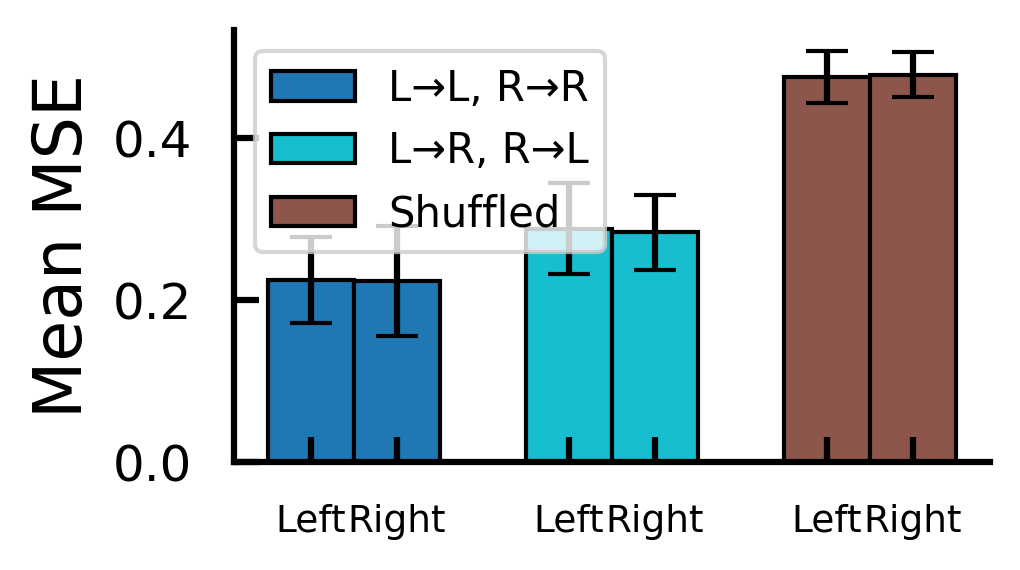

In [28]:
import numpy as np
import matplotlib.pyplot as plt



# Categories to average
categories = [('L', 'R'), ('L from R', 'R from L'), ('L from R Shuffled', 'R from L Shuffled')]

# Collect values for each category across animals
category_values = {pair: ([mse_all_animals[animal][pair[0]] for animal in mse_all_animals], [mse_all_animals[animal][pair[1]] for animal in mse_all_animals]) for pair in categories}

# Calculate mean and std for each pair
means = [(np.mean(category_values[pair][0]), np.mean(category_values[pair][1])) for pair in categories]
stds = [(np.std(category_values[pair][0]), np.std(category_values[pair][1])) for pair in categories]

# Flatten mean and std values for plotting
mean_vals = [val for pair in means for val in pair]
std_vals = [val for pair in stds for val in pair]

# Define x positions for L and R pairs (group them together)
x = np.array([0, 0.5, 1.5, 2.0, 3.0, 3.5])

# Set up the figure with smaller size
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)

# Define colors for each pair group
colors = ['#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c', '#9467bd', '#9467bd']
colors = ['#1f77b4', '#1f77b4', '#17becf', '#17becf', '#8c564b', '#8c564b']

labels = ['L→L, R→R', 'L→R, R→L', 'Shuffled']

# Creating a dummy plot to generate custom legend entries
legend_bars = [plt.Rectangle((0, 0), 1, 1, fc=colors[i], edgecolor='black') for i in [0, 2, 4]]
ax.legend(legend_bars, labels, fontsize=10, loc='upper left')
#
# Create the bar plot with error bars (std) and grouped L/R pairs
ax.bar(x, mean_vals, yerr=std_vals, capsize=5, color=colors, edgecolor='black', width=0.5)

# Add labels and title
#ax.set_xlabel('Categories', fontsize=16)
ax.set_ylabel('Mean MSE', fontsize=16)
#ax.set_title('Mean and Standard Deviation of Left and Right Data', fontsize=14)

# Customize x-axis ticks and labels (Left and Right below each bar)
ax.set_xticks(x)
ax.set_xticklabels(['Left', 'Right', 'Left', 'Right', 'Left', 'Right'], fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Add grid for better readability
#ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adjust font size for axis labels
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(16)

# Tight layout for better spacing
plt.tight_layout()
#plt.savefig(savefolder+'MSE_errors_'+phase+'.svg', format='svg', dpi=300)

# Save figure (publication-ready)
plt.show()



C:\Users\hamed\AppData\Local\Temp\ipykernel_17776\2201030881.py:27: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.9.
  bar.set_hatch(pattern)


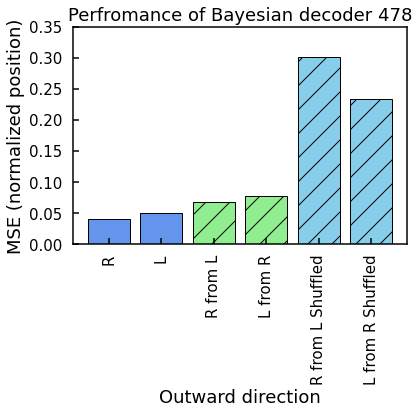

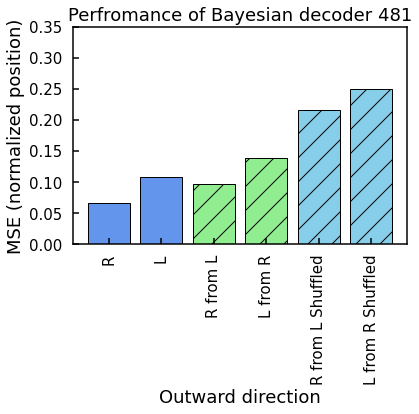

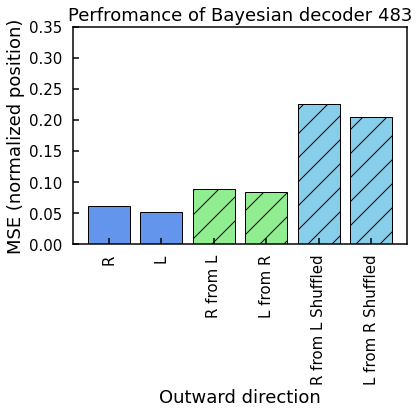

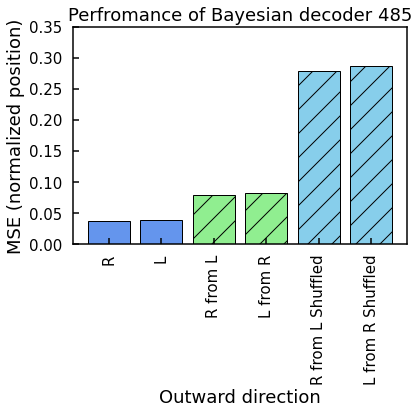

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
animal_names=['478','481','483','485']
mse_loaeded={}
for anim in animal_names:
    mse_loaeded[anim]=np.load(savefolder+anim+'ML',allow_pickle=True)
    # Data
    categories = mse_loaeded[anim].keys()#['Right', 'R from L', 'Left', 'L from R']
    MSEs = mse_loaeded[anim].values()

    MSEs=[mse_loaeded[anim][x]['mse'] for x in categories]
    #[data_info["R"]['mse'],mse_L_R,data_info["L"]['mse'],mse_R_L]

    # Colors
    colors = ['cornflowerblue', 'cornflowerblue', 'lightgreen', 'lightgreen', 'skyblue', 'skyblue']

    # Hatch patterns
    patterns = [' ', ' ','/', '/ ', '/', '/']

    # Plot
    bars = plt.bar(categories, MSEs, color=colors,edgecolor='k')

    # Apply hatch patterns
    for bar, pattern in zip(bars, patterns):
        if pattern != ' ':
            bar.set_hatch(pattern)

    plt.xlabel('Outward direction',fontsize=18)
    plt.ylabel('MSE (normalized position)',fontsize=18)
    plt.title('Perfromance of Bayesian decoder '+anim,fontsize=18)
    plt.xticks(rotation=90)

    plt.ylim([0,.35])
    plt.show()